In [1]:
from SDP_interaction_inference.constraints import Constraint
from SDP_interaction_inference import optimization
from SDP_interaction_inference.dataset import Dataset
from SDP_interaction_inference.correlation import Correlation
from SDP_interaction_inference import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import scipy
import tqdm
from copy import deepcopy
import matplotlib.patches
import corner
import plotly
import plotly.graph_objects as go

# Capture Estimation

Inconsistency between BayNorm (R) capture estimation and python translation was due to missing constant of 1.4826 in median absolute deviation function.

Also had log(0) warning: had filtered genes with mean < 1 and then removed outlying cell, which left one gene with mean 0 and several others with means < 1, so have re-done data-processing to remove cell first.

Now use fixed estimation method on new data:

## Data loading

In [2]:
# read FIB counts
data_FIB = pd.read_csv("../Data/GSE151334_FIB_counts_thresh.csv", index_col=0)
data_FIB.head()

,Fibroblasts_A10_S10,Fibroblasts_A11_S11,Fibroblasts_A2_S2,Fibroblasts_A3_S3,Fibroblasts_A4_S4,Fibroblasts_A5_S5,Fibroblasts_A7_S7,Fibroblasts_A8_S8,Fibroblasts_B10_S34,Fibroblasts_B11_S35,...,Fibroblasts_P17_S377,Fibroblasts_P18_S378,Fibroblasts_P1_S361,Fibroblasts_P21_S381,Fibroblasts_P22_S382,Fibroblasts_P3_S363,Fibroblasts_P4_S364,Fibroblasts_P5_S365,Fibroblasts_P6_S366,Fibroblasts_P8_S368
7SK,18,3,6,8,35,0,0,21,9,9,...,10,61,23,19,5,3,23,15,1,14
A4GALT,0,0,0,0,0,0,0,0,0,28,...,0,0,0,0,0,0,0,0,0,0
AAAS,0,0,0,0,0,0,0,0,3,4,...,0,0,0,0,0,0,5,0,0,0
AACS,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,4,55,22,42
AADAT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## BayNorm translated capture function

In [3]:
def mad(x):
    """
    Exact replication of R's mad():
    mad(x, constant = 1.4826, center = median(x))
    """
    x = np.asarray(x)
    x = x[~np.isnan(x)]  # match R's na.rm = TRUE behavior
    med = np.median(x)
    return 1.4826 * np.median(np.abs(x - med))

In [4]:
def Check_input(Data):
    """
    Minimal placeholder for the R Check_input().
    Ensures Data is a numeric pandas DataFrame.
    """
    if not isinstance(Data, pd.DataFrame):
        Data = pd.DataFrame(Data)
    return Data.astype(float)

In [5]:
def BetaFun(Data, MeanBETA):
    # Set matrix as object for input data
    Data = Check_input(Data)

    # Column sums
    xx = Data.sum(axis=0)

    # Normcount <- t(t(Data)/xx) * mean(xx)
    Normcount = Data.div(xx, axis=1) * xx.mean()

    # Row means
    means = Normcount.mean(axis=1)
    lmeans = np.log(means)

    # Row-wise median and MAD of log(Normcount + 1)
    log_norm = np.log(Normcount + 1)

    med = log_norm.apply(np.median, axis=1)
    mad_vals = log_norm.apply(mad, axis=1)

    bound = med + 3 * mad_vals

    # Row-wise max
    maxlogGene = log_norm.max(axis=1)

    # ind <- which(maxlogGene < bound)
    ind = maxlogGene[maxlogGene < bound].index

    # dropout rate per gene
    dropout = (Data == 0).sum(axis=1) / Data.shape[1]

    # Select_ind <- intersect(ind, which(dropout < 0.35))
    Select_ind = ind.intersection(dropout[dropout < 0.35].index)

    Selected_genes = Select_ind.to_numpy()

    # temppp <- colSums(Data[Select_ind, ])
    temppp = Data.loc[Select_ind].sum(axis=0)

    # BETA <- temppp/mean(temppp) * MeanBETA
    BETA = temppp / temppp.mean() * MeanBETA

    # Truncate BETA values
    if (BETA >= 1).any():
        BETA[BETA >= 1] = BETA[BETA < 1].max()

    if (BETA <= 0).any():
        BETA[BETA <= 0] = BETA[BETA > 0].min()

    # names(BETA) <- colnames(Data)
    BETA.index = Data.columns

    return {
        "BETA": BETA,
        "Selected_genes": Selected_genes
    }

## Run & Compare to BayNorm (R)

In [6]:
# run
beta_dict = BetaFun(data_FIB, 0.1)
beta = beta_dict['BETA'].to_numpy()

In [8]:
# Run BayNorm in R and load estimated capture
beta_baynorm = []
with open("bayNorm_example.txt", "r") as file:
    for i, line in enumerate(file):
        if i % 2:
            vals = [float(x) for x in line.rstrip().split(' ') if x != '']
            beta_baynorm += vals
beta_baynorm = np.array(beta_baynorm)

In [ ]:
# produces same result
np.allclose(beta, beta_baynorm)

True

## Save

In [15]:
np.savetxt("beta_FIB.txt", beta)

## Slightly different to 'Basic' method

Normalize total cell counts to set mean capture, but BayNorm additionally filters out some genes from the computation

In [11]:
def estimate_capture_basic(df, beta_mean=0.1):

    total_cell_counts = df.sum(axis='rows')
    total_counts_mean = total_cell_counts.mean()
    beta_basic = np.array(total_cell_counts / total_counts_mean) * beta_mean
    
    return beta_basic

In [12]:
beta_basic = estimate_capture_basic(data_FIB)

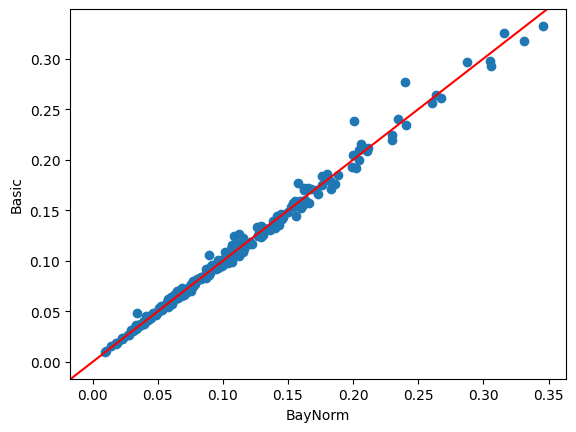

In [19]:
plt.scatter(beta, beta_basic)
plt.axline([0, 0], [0.1, 0.1], color="red")
plt.xlabel("BayNorm")
plt.ylabel("Basic")
plt.show()